# Deep Learning
## Practical Session 05

# Recurrent Neural Networks with Attention Mechanism


## Part 1 - Movie Review Classification with LSTMs

### Data preprocessing

In [ ]:
from keras.datasets import imdb  
from keras.preprocessing import sequence

# initialization
num_words = 2500  # number of words to consider as features
maxlen = 200  # cut texts after this number of words (among top max_features most common words)

pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, start_char=start_id, oov_char=oov_id, index_from=index_offset)

word2idx = imdb.get_word_index()
idx2word = {v + index_offset: k for k,v in word2idx.items()}

idx2word [pad_id]= '<PAD>'
idx2word [start_id]= '<START>'
idx2word [oov_id]= '<OOV>'

x_train = sequence.pad_sequences(x_train, maxlen=maxlen, truncating='post', padding='post', value=pad_id)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, truncating='post', padding='post', value=pad_id)

# Reducing the size of the dataset
x_train = x_train[:5000]
y_train = y_train[:5000]
x_test = x_test[:5000]
y_test = y_test[:5000]
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
x_train shape: (5000, 200)
x_test shape: (5000, 200)


``` python
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)
```

### Exercise 1 - Building the LSTM model

Now, create a self embedding layer and embed the input sentences as a vector of numbers. There are two main approaches to perform this embedding pre-trained embeddings like Word2Vec or GloVe or randomly initializing. 

In this tutorial, we will be using a random initialization. To perform this embedding we use the `embedding` function from the layers package.The parameters of this matrix will then be trained with the rest of the graph.

Let's apply this idea to our sentiment prediction task. We will use functional API to construct the model because it is more flexible and branching or sharing of layers is allowed. Your model should use 32-dimensional word embeddings. After the embedding layer, we will put an LSTM layer of 64 units. 

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Input
from keras.models import Model
from keras.regularizers import l2

inputs1 = Input(shape = (maxlen,))
x1 = Embedding(num_words, 32, input_length = maxlen, embeddings_regularizer = l2(.001))(inputs1) 
recurrent_output = LSTM(64, dropout = 0.3, recurrent_dropout = 0.2)(x1)
outputs1 = Dense(1,activation = 'sigmoid')(recurrent_output)
model_lstm = Model(inputs1, outputs1)
model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model_lstm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 200, 32)           80000     
                                                                 
 lstm_13 (LSTM)              (None, 64)                24832     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 104,897
Trainable params: 104,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

lstm_history = model_lstm.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=10, verbose=2, callbacks = [callback])
score, acc = model_lstm.evaluate(x_test, y_test)

Epoch 1/10
79/79 - 30s - loss: 0.7068 - acc: 0.5086 - val_loss: 0.6945 - val_acc: 0.4858 - 30s/epoch - 376ms/step
Epoch 2/10
79/79 - 27s - loss: 0.6932 - acc: 0.5038 - val_loss: 0.6948 - val_acc: 0.4892 - 27s/epoch - 343ms/step
Epoch 3/10
79/79 - 27s - loss: 0.6921 - acc: 0.5126 - val_loss: 0.6881 - val_acc: 0.5522 - 27s/epoch - 341ms/step
Epoch 4/10
79/79 - 28s - loss: 0.6919 - acc: 0.5446 - val_loss: 0.6752 - val_acc: 0.5888 - 28s/epoch - 355ms/step
Epoch 5/10
79/79 - 28s - loss: 0.6389 - acc: 0.6720 - val_loss: 0.7471 - val_acc: 0.6982 - 28s/epoch - 355ms/step
Epoch 6/10
79/79 - 29s - loss: 0.6283 - acc: 0.7290 - val_loss: 0.7623 - val_acc: 0.6190 - 29s/epoch - 368ms/step
Epoch 7/10
79/79 - 28s - loss: 0.6275 - acc: 0.7266 - val_loss: 0.5827 - val_acc: 0.7618 - 28s/epoch - 354ms/step
Epoch 8/10
79/79 - 28s - loss: 0.6208 - acc: 0.7378 - val_loss: 0.6975 - val_acc: 0.6720 - 28s/epoch - 352ms/step
Epoch 9/10
79/79 - 28s - loss: 0.6644 - acc: 0.7088 - val_loss: 0.7190 - val_acc: 0.5106

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

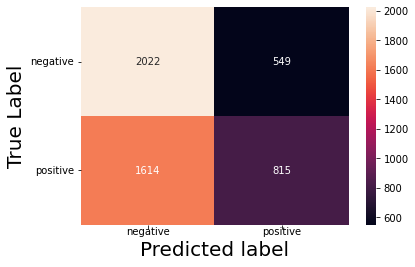

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# predict probabilities for test set
yhat_probs = model_lstm.predict(x_test, verbose=0)
# predict classes for test set
yhat_classes = np.where(yhat_probs>0.5, 1, 0)

p = sns.heatmap(confusion_matrix(y_test, yhat_classes), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)
p.xaxis.set_ticklabels(['negative', 'positive'], ha="center", va="center")
p.yaxis.set_ticklabels(['negative', 'positive'], rotation=0, va="center")

## Exercise 2 - LSTM + attention neural network on IMDB movie reviews

### Create Attention Layer

In [ ]:
import tensorflow as tf
from keras.layers import Layer, Input, Dropout, Bidirectional
from keras.layers import *
from keras.models import *
from keras import backend as K

# Add attention layer to the deep learning network

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1), initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
from keras.layers import Embedding, Dense, LSTM, Input
from keras.models import Model
from keras.regularizers import l2

### PUT YOUR CODE HERE ###
inputs=Input((maxlen,))
x = Embedding(num_words, 32, input_length=maxlen, embeddings_regularizer = l2(.001))(inputs)
att_in = LSTM(64, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.2)(x)
att_out = attention()(att_in)
outputs = Dense(1, activation='sigmoid', trainable = True)(att_out)
### END ###

model_attention = Model(inputs, outputs)
model_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_attention.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_14 (Embedding)    (None, 200, 32)           80000     
                                                                 
 lstm_14 (LSTM)              (None, 200, 64)           24832     
                                                                 
 attention_6 (attention)     (None, 64)                264       
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 105,161
Trainable params: 105,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

#Fit the model with attention for 10 epoch, batch size of 64, with early stopping

history_att = model_attention.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_data = (x_test, y_test),
                    verbose = 2,
                    callbacks = [callback])


result = model_attention.evaluate(x_test, y_test)
print(result)

Epoch 1/10
79/79 - 32s - loss: 0.7013 - accuracy: 0.5352 - val_loss: 0.6802 - val_accuracy: 0.6034 - 32s/epoch - 403ms/step
Epoch 2/10
79/79 - 29s - loss: 0.6465 - accuracy: 0.6468 - val_loss: 0.6405 - val_accuracy: 0.6728 - 29s/epoch - 361ms/step
Epoch 3/10
79/79 - 30s - loss: 0.5969 - accuracy: 0.7492 - val_loss: 0.7095 - val_accuracy: 0.6904 - 30s/epoch - 377ms/step
Epoch 4/10
79/79 - 30s - loss: 0.5146 - accuracy: 0.8038 - val_loss: 0.4842 - val_accuracy: 0.7958 - 30s/epoch - 374ms/step
Epoch 5/10
79/79 - 29s - loss: 0.4303 - accuracy: 0.8410 - val_loss: 0.5217 - val_accuracy: 0.7862 - 29s/epoch - 363ms/step
Epoch 6/10
79/79 - 32s - loss: 0.3982 - accuracy: 0.8660 - val_loss: 0.5162 - val_accuracy: 0.7818 - 32s/epoch - 410ms/step
Epoch 7/10
79/79 - 35s - loss: 0.3760 - accuracy: 0.8772 - val_loss: 0.5558 - val_accuracy: 0.7938 - 35s/epoch - 445ms/step
Epoch 7: early stopping
157/157 [==============================] - 5s 34ms/step - loss: 0.5558 - accuracy: 0.7938
[0.555790722370147

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

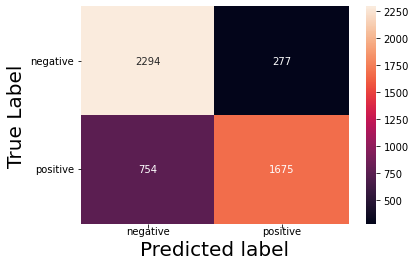

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# predict probabilities for test set
yhat_probs = model_attention.predict(x_test, verbose=0)
# predict classes for test set
yhat_classes = np.where(yhat_probs>0.5, 1, 0)

p = sns.heatmap(confusion_matrix(y_test, yhat_classes), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)
p.xaxis.set_ticklabels(['negative', 'positive'], ha="center", va="center")
p.yaxis.set_ticklabels(['negative', 'positive'], rotation=0, va="center")

## Part 2 - Sequence-to-sequence learning for performing additions

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys    
import numpy as np 

#to call functions from another file, we need to append its path then import it from this path
path_to_module = '/content/drive/MyDrive/Deep_Learning_Spring23/Practical 5'
sys.path.append(path_to_module)
from charactertable import CharacterTable
from additions_dataset import load_data


# Parameters for dataset.
num_examples = 1000 #we will have 1000 calculations in our dataset
max_num_digits = 2
maxlen_input = 2 * max_num_digits + 1 # max '99+99' --> 5 digit (1 for + sign)
reverse = False
# All the numbers, plus sign and s/e for <SOS>/<EOS>.
chars = '0123456789+se'
ctable = CharacterTable(chars) #we initialize character table with those characters

print('Generating data...')
questions, expected = load_data(num_examples, max_num_digits, reverse)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), maxlen_input, ctable.num_tokens))
y = np.zeros((len(questions), max_num_digits + 3, ctable.num_tokens))
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen_input)
# Characters 's' and 'e' correspond to <SOS> and <EOS>
for i, sentence in enumerate(expected):
    y[i] = ctable.encode('s' + sentence + 'e', max_num_digits + 3) #C: string, to be encoded.
                    #num_rows: Number of rows in the returned one-hot encoding. This is used to keep the # of rows for each data the same.
    
# Explicitly set apart 10% for validation and test data.
num_examples_val = len(x) // 10
split_at_val = len(x) - num_examples_val * 2
split_at_test = len(x) - num_examples_val
x_train = x[:split_at_val]
y_train = y[:split_at_val]
x_val = x[split_at_val:split_at_test]
y_val = y[split_at_val:split_at_test]
x_test = x[split_at_test:]
y_test = y[split_at_test:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)
print('Validation Data:')
print(x_val.shape)
print(y_val.shape)
print('Test Data:')
print(x_test.shape)
print(y_test.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generating data...
Total addition questions: 1000
Vectorization...
Training Data:
(800, 5, 14)
(800, 5, 14)
Validation Data:
(100, 5, 14)
(100, 5, 14)
Test Data:
(100, 5, 14)
(100, 5, 14)


### Exercise 3 - Building the model for training





In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, GRU

# Parameters for the model.
hidden_size = 32

# Define an input sequence and process it.
encoder_inputs = Input(shape=(maxlen_input, ctable.num_tokens))
encoder_rnn_layer = GRU(hidden_size, return_state=True)
# We discard the output of the layer and only keep the states.
_, encoder_state = encoder_rnn_layer(encoder_inputs)

### UPDATE CODE HERE ###
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, ctable.num_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_rnn_layer = GRU(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_rnn_layer(decoder_inputs,
                                       initial_state=encoder_state)
decoder_dense = Dense(ctable.num_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
### END ###

# Define the model that will turn
# `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 5, 14)]      0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, None, 14)]   0           []                               
                                                                                                  
 gru_14 (GRU)                   [(None, 32),         4608        ['input_31[0][0]']               
                                 (None, 32)]                                                      
                                                                                                  
 gru_15 (GRU)                   [(None, None, 32),   4608        ['input_32[0][0]',        

In [9]:
print(x_train[0,:,:]) #x_train will be our encoder_input_data (num_pairs, max_query_sequence_length, num_tokens)
print(y_train[0, :, :-1]) # y_train[:, :-1] will be our decoder_input_data (num_pairs, max_answer_sequence_length, num_tokens)
print(y_train[0, :, 1:])# y_train[:, 1:] will be our decoder_target_data is the same as decoder_input_data but offset by one timestep.

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
num_epochs = 100
batch_size = 16

history = model.fit([x_train, y_train[:, :-1]], y_train[:, 1:], #[encoder_input_data, decoder_input_data], decoder_target_data
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=([x_val, x_val[:, :-1]], y_val[:, 1:]),
                    verbose=2)

Epoch 1/100
50/50 - 3s - loss: 2.3189 - accuracy: 0.3128 - val_loss: 2.0470 - val_accuracy: 0.3875 - 3s/epoch - 59ms/step
Epoch 2/100
50/50 - 0s - loss: 1.8243 - accuracy: 0.4681 - val_loss: 1.8118 - val_accuracy: 0.4275 - 141ms/epoch - 3ms/step
Epoch 3/100
50/50 - 0s - loss: 1.6194 - accuracy: 0.5391 - val_loss: 1.7302 - val_accuracy: 0.4325 - 132ms/epoch - 3ms/step
Epoch 4/100
50/50 - 0s - loss: 1.4829 - accuracy: 0.5403 - val_loss: 1.6795 - val_accuracy: 0.4700 - 146ms/epoch - 3ms/step
Epoch 5/100
50/50 - 0s - loss: 1.3857 - accuracy: 0.5419 - val_loss: 1.6117 - val_accuracy: 0.4725 - 127ms/epoch - 3ms/step
Epoch 6/100
50/50 - 0s - loss: 1.3242 - accuracy: 0.5472 - val_loss: 1.6269 - val_accuracy: 0.4925 - 132ms/epoch - 3ms/step
Epoch 7/100
50/50 - 0s - loss: 1.2892 - accuracy: 0.5506 - val_loss: 1.6086 - val_accuracy: 0.4875 - 133ms/epoch - 3ms/step
Epoch 8/100
50/50 - 0s - loss: 1.2641 - accuracy: 0.5537 - val_loss: 1.6834 - val_accuracy: 0.5075 - 136ms/epoch - 3ms/step
Epoch 9/10

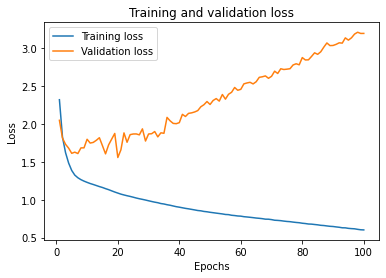

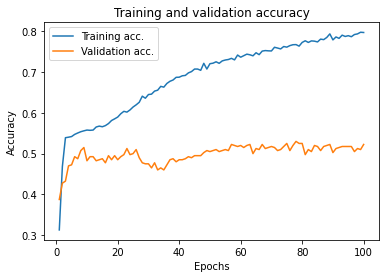

In [ ]:
import matplotlib.pyplot as plt

def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

### Exercise 4 - Building the model for inference

In [ ]:
encoder_model = Model(encoder_inputs, encoder_state)

decoder_state_input = Input(shape=(hidden_size,))
decoder_outputs, decoder_state = decoder_rnn_layer(
    decoder_inputs, initial_state=decoder_state_input)
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs, decoder_state_input],
    [decoder_outputs, decoder_state])

In [ ]:
def decode_sequence(input_seq, max_decoder_seq_length):
    # Encode the input as state vectors.
    state_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, ctable.num_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, ctable.char_indices['s']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, state_value = decoder_model.predict(
            [target_seq, state_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = ctable.indices_char[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'e' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, ctable.num_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

    return decoded_sentence


In [ ]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'
    
# Select 10 samples from the validation set at random so we can visualize
# errors.
for i in range(10):
    ind = np.random.randint(0, len(x_test))
    q, ea = x_test[np.array([ind])], y_test[np.array([ind])]
    pred = decode_sequence(q, max_num_digits + 2)[:-1]
    q = ctable.decode(q[0])
    correct = ctable.decode(ea[0])[1:-1]
    print('Q', q[::-1] if reverse else q, end=' ')
    print('T', correct, end=' ')
    if correct == pred:
        print(colors.ok + '☑' + colors.close, end=' ')
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(pred)

Q 36+13 T 49 ☒ 50
Q 30+57 T 87 ☒ 89
Q 63+91 T 154 ☑ 154
Q 13+77 T 90 ☒ 98
Q 4+75 T 79 ☒ 89
Q 16+50 T 66 ☒ 60
Q 53+76 T 129 ☑ 129
Q 91+47 T 138 ☒ 139
Q 47+93 T 140 ☒ 149
Q 36+13 T 49 ☒ 50
